<img src="img/se4g_pic1.png">

In [1]:
from jupyter_dash import JupyterDash
import dash
from dash import dcc, html
import pandas as pd
import os
from datetime import datetime
from se4g_helper import *
import ipywidgets as widgets
import psycopg2
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'jupyter_dash'

In [3]:
engine = connect_with_sqlalchemy()


connected with  localhost  through sqlalchemy
connected with  localhost  through psycopg2


Load dashboard table

In [4]:
def create_df_from_table(table_name,conn = conn):
    
    cursor = conn.cursor()

    # Generate the SQL statement to select data from the source table
    select_data_query = f"SELECT * FROM {table_name};"

    # Execute the SELECT command
    cursor.execute(select_data_query)

    columns = [desc[0] for desc in cursor.description]

    # Fetch all the rows
    rows = cursor.fetchall()

    cursor.close()
    conn.close()

    # Create a pandas DataFrame from the fetched rows
    df = pd.DataFrame(rows, columns=columns)
    print(f'df {table_name} created')
    return df

In [7]:
#from this I will obtain a DF that contains all the columns and the rows of our table pollutant_detection
conn = connect_right_now()

table_name='pollutant_detection'

df_pollutant=create_df_from_table(table_name,conn)

df_pollutant.head()

connected with  localhost  through psycopg2


In [13]:
df_pollutant.head()

,station_code,pollutant,value_datetime_begin,value_datetime_end,value_numeric,samplingpoint_x,samplingpoint_y
0,AD0942A,CO,2023-05-30 09:00:00+01:00,2023-05-30 10:00:00+01:00,0.1,1.539138,42.509694
1,AD0942A,CO,2023-05-30 10:00:00+01:00,2023-05-30 11:00:00+01:00,0.1,1.539138,42.509694
2,AD0942A,CO,2023-05-30 11:00:00+01:00,2023-05-30 12:00:00+01:00,0.1,1.539138,42.509694
3,AD0942A,CO,2023-05-30 12:00:00+01:00,2023-05-30 13:00:00+01:00,0.1,1.539138,42.509694
4,AD0942A,CO,2023-05-30 13:00:00+01:00,2023-05-30 14:00:00+01:00,0.1,1.539138,42.509694


In [11]:
df_pollutant.describe()

,value_numeric,samplingpoint_x,samplingpoint_y
count,1.575917e+06,1.765946e+06,1.765946e+06
mean,9.339360e+00,5.278903e+00,4.559729e+01
std,2.667145e+01,9.901418e+00,6.861315e+00
min,-4.321000e+01,-1.792167e+01,2.777260e+01
25%,1.000125e+00,-3.112980e+00,4.115078e+01
50%,5.000000e+00,7.003174e+00,4.709436e+01
75%,1.300000e+01,1.297460e+01,5.065323e+01
max,5.042000e+03,3.334778e+01,6.847701e+01


In [17]:
#from this we will obtain a df that contains all the columns and the rows of our station table

conn = connect_right_now()
table_name = 'station'

df_station=create_df_from_table(table_name, conn)

df_station.head()

connected with  localhost  through psycopg2


In [21]:
df_station.head()

,station_code,station_name,station_altitude,network_countrycode,samplingpoint_x,samplingpoint_y
0,AD0942A,Escaldes-Engordany,1080.0,AD,1.539138,42.509694
1,AT0ENK1,Enzenkirchen im Sauwald,525.0,AT,13.670860,48.391640
2,AT0ILL1,Illmitz am Neusiedler See,117.0,AT,16.766390,47.770280
3,AT0KLH1,Klöch bei Bad Radkersburg,417.0,AT,15.956300,46.767200
4,AT0PIL1,Pillersdorf bei Retz,315.0,AT,15.936000,48.721200


In [19]:
df_station.describe()

,station_altitude,samplingpoint_x,samplingpoint_y
count,1536.000000,1536.000000,1536.000000
mean,253.980534,6.626442,46.832157
std,287.681201,9.697591,6.991689
min,0.000000,-17.921671,27.772597
25%,35.000000,-1.260764,41.754670
50%,158.000000,8.249244,48.163484
75%,398.500000,13.469503,51.059068
max,3106.000000,33.347778,68.477010


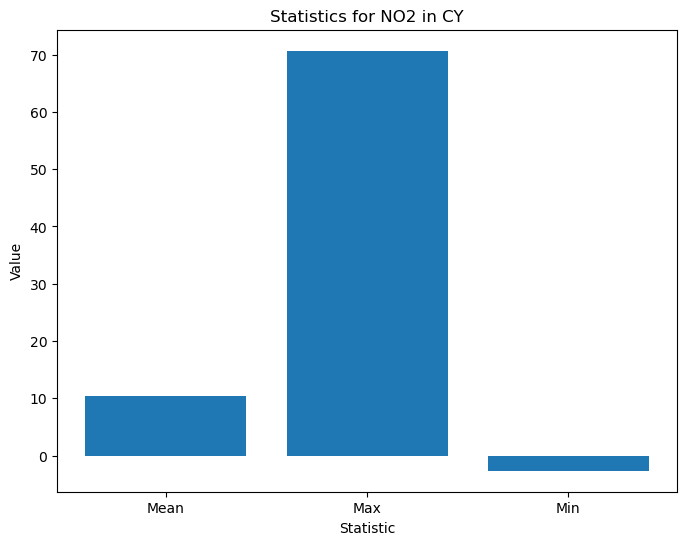

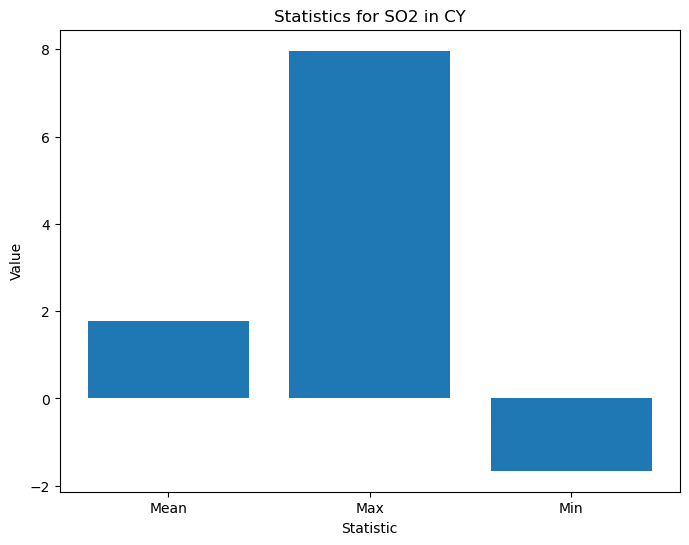

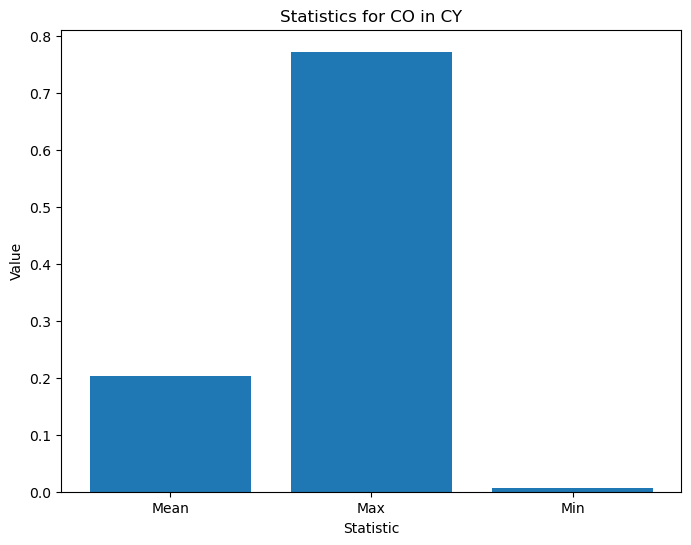

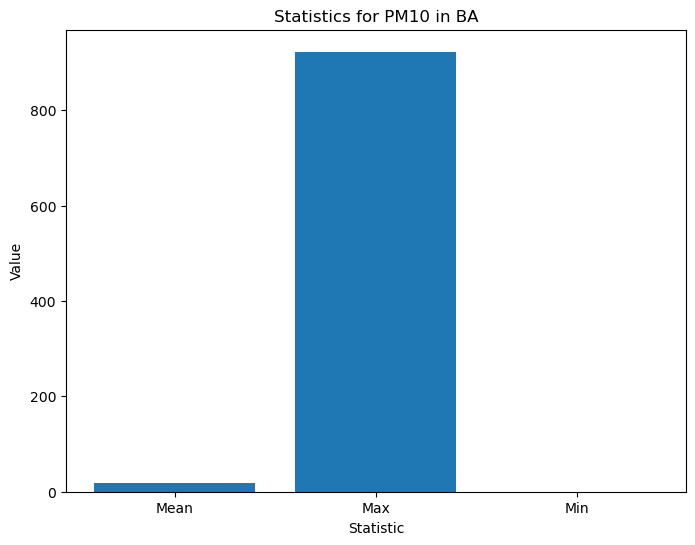

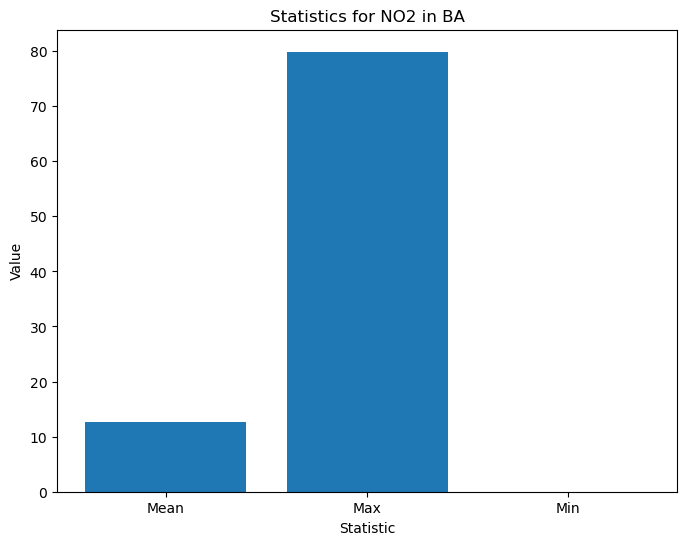

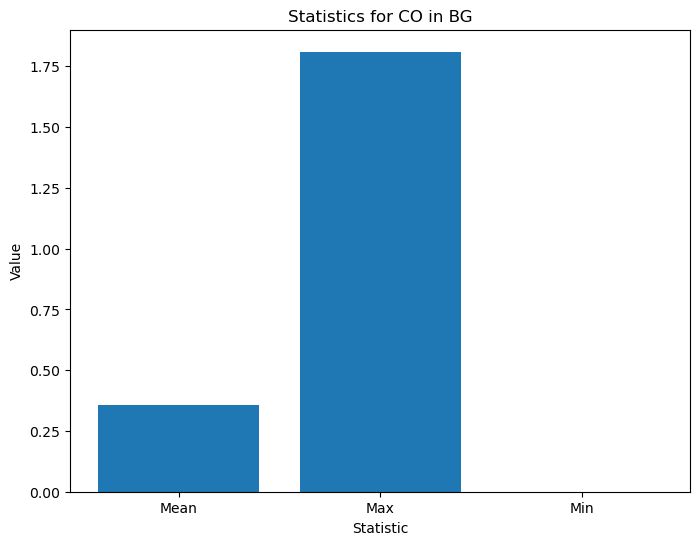

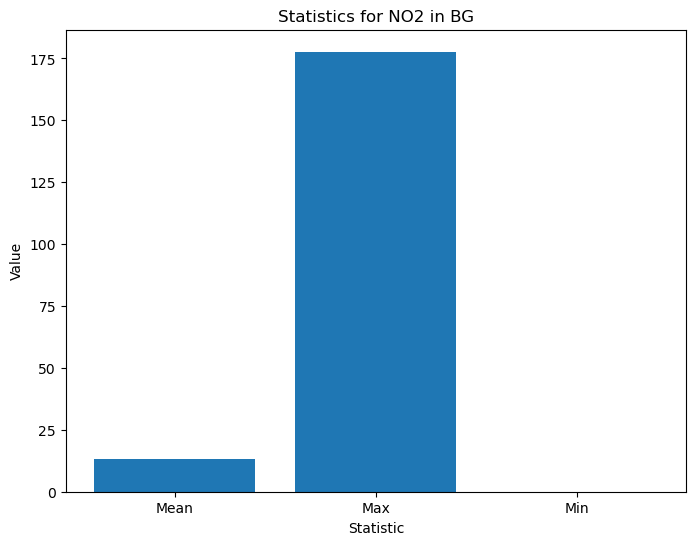

In [22]:
# Dropdown widgets for country and pollutant selection
country_dropdown = widgets.Dropdown(
    options=df_station['network_countrycode'].unique(),
    description='Country:'
)

pollutant_dropdown = widgets.Dropdown(
    description='Pollutant:'
)

# Text widget to display statistics
statistics_text = widgets.Textarea(
    description='Statistics:',
    disabled=True,
    layout={'width': '500px', 'height': '200px'}
)

# Function to update pollutants based on selected country
def update_pollutants(change):
    country = country_dropdown.value
    
    if country:
        pollutants = df_pollutant[df_pollutant['station_code'].isin(df_station[df_station['network_countrycode'] == country]['station_code'])]['pollutant'].unique()
        pollutant_dropdown.options = pollutants
        pollutant_dropdown.disabled = False
    else:
        pollutant_dropdown.options = []
        pollutant_dropdown.disabled = True

# Function to update statistics based on user selection
def update_statistics(change):
    country = country_dropdown.value
    pollutant = pollutant_dropdown.value
    
    filtered_df = df_pollutant.merge(df_station, on='station_code')
    filtered_df = filtered_df[(filtered_df['network_countrycode'] == country) & (filtered_df['pollutant'] == pollutant)]
    
    mean_value = filtered_df['value_numeric'].mean()
    max_value = filtered_df['value_numeric'].max()
    min_value = filtered_df['value_numeric'].min()
    
    statistics_text.value = f"Mean: {mean_value:.2f}\nMax: {max_value}\nMin: {min_value}"

# Event listeners for dropdown selection
country_dropdown.observe(update_pollutants, 'value')
pollutant_dropdown.observe(update_statistics, 'value')

In [23]:
def plot_statistics(change):
    country = country_dropdown.value
    pollutant = pollutant_dropdown.value
    
    filtered_df = df_pollutant.merge(df_station, on='station_code')
    filtered_df = filtered_df[(filtered_df['network_countrycode'] == country) & (filtered_df['pollutant'] == pollutant)]
    
    mean_value = filtered_df['value_numeric'].mean()
    max_value = filtered_df['value_numeric'].max()
    min_value = filtered_df['value_numeric'].min()
    
    statistics_text.value = f"Mean: {mean_value:.2f}\nMax: {max_value}\nMin: {min_value}"
    
    # Create a bar plot of the statistics
    stats = [mean_value, max_value, min_value]
    labels = ['Mean', 'Max', 'Min']
    
    plt.figure(figsize=(8, 6))
    plt.bar(labels, stats)
    plt.xlabel('Statistic')
    plt.ylabel('Value')
    plt.title(f'Statistics for {pollutant} in {country}')
    plt.show()

# Event listener for dropdown selection
pollutant_dropdown.observe(plot_statistics, 'value')

# Display widgets
display(country_dropdown)
display(pollutant_dropdown)
display(statistics_text)

Dropdown(description='Country:', options=('AD', 'AT', 'BA', 'BE', 'BG', 'CH', 'CY', 'CZ', 'DE', 'DK', 'EE', 'E…

Dropdown(description='Pollutant:', options=(), value=None)

Textarea(value='', description='Statistics:', disabled=True, layout=Layout(height='200px', width='500px'))

In [ ]:
#NEW PLOT --> NOT SURE THAT PLOTS ARE GOOD 


import ipywidgets as widgets
import pandas as pd
from IPython.display import display

def select_pollutant(df_pollutant):
    pollutants = df_pollutant['pollutant'].unique()
    dropdown_pollutant = widgets.Dropdown(
        options=pollutants,
        description='Select pollutant:',
        layout=widgets.Layout(width='300px')
    )
    display(dropdown_pollutant)
    return dropdown_pollutant

def select_date(df_pollutant):
    df_pollutant['value_datetime_begin'] = pd.to_datetime(df_pollutant['value_datetime_begin'])
    dates = df_pollutant['value_datetime_begin'].dt.date.unique()
    dropdown_date = widgets.Dropdown(
        options=dates,
        description='Select date:',
        layout=widgets.Layout(width='300px')
    )
    display(dropdown_date)
    return dropdown_date

# Esempio di utilizzo
selected_pollutant = select_pollutant(df_pollutant)
selected_date = select_date(df_pollutant)

print("Selected pollutant:", selected_pollutant.value)
print("Selected date:", selected_date.value)


In [ ]:
import pandas as pd
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource
from bokeh.palettes import Category10
from bokeh.io import output_notebook
import ipywidgets as widgets
from IPython.display import display


# Funzione per creare il grafico Bokeh
def create_bokeh_plot(df_pollutant, station, selected_pollutant, selected_date):
    df_selected = df_pollutant[(df_pollutant['pollutant'] == selected_pollutant) &
                               (df_pollutant['value_datetime_begin'].dt.date == selected_date)]
    
    # Merge the station and df_pollutant DataFrames on station_code
    df_country = pd.merge(station, df_selected, on='station_code')
    
    countries = df_country['network_countrycode'].unique()
    colors = Category10[10][:len(countries)]

    p = figure(x_axis_type='datetime', title=f"Pollutant: {selected_pollutant} - Date: {selected_date}",
               width=800, height=400)

    for country, color in zip(countries, colors):
        df_filtered = df_country[df_country['network_countrycode'] == country]
        df_filtered = df_filtered.sort_values('value_datetime_begin')  # Sort by 'value_datetime_begin'
        source = ColumnDataSource(df_filtered)
        p.line(x='value_datetime_begin', y='value_numeric', source=source, line_color=color,
               legend_label=country)

    p.legend.location = "top_left"
    p.legend.click_policy = "hide"

    output_notebook()
    show(p)


create_bokeh_plot(df_pollutant, df_station, selected_pollutant.value, selected_date.value)



table_name = 'se4g_dashboard'

conn = connect_right_now()
cursor = conn.cursor()

# Generate the SQL statement to select data from the source table
select_data_query = f"SELECT * FROM {table_name};"

# Execute the SELECT command
cursor.execute(select_data_query)

columns = [desc[0] for desc in cursor.description]

# Fetch all the rows
rows = cursor.fetchall()

cursor.close()
conn.close()

# Create a pandas DataFrame from the fetched rows
df = pd.DataFrame(rows, columns=columns)

unique_month_day = df['month_day'].unique()
month_day_dict = {day: index+1 for index, day in enumerate(unique_month_day)}

df['time_series'] = df['month_day'].map(month_day_dict)
df = df[df['country'] != 'Bosnia and Herzegovina']

df['month_day_date'] = '2023' + df['month_day'].astype(str)
df['month_day_date'] = pd.to_datetime(df['month_day_date'], format='%Y%m%d')


In [ ]:
print(df.head())

In [ ]:
print(df['month_day'].unique())

In [ ]:
# Find duplicate rows based on 'pollutant', 'country', and 'month_day' columns
duplicate_rows = df[df.duplicated(subset=['pollutant', 'country', 'month_day'], keep=False)]

# Group duplicate rows by 'pollutant' and 'country' and print them
for (pollutant, country), group in duplicate_rows.groupby(['pollutant', 'country']):
    print(f"Duplicate rows for pollutant '{pollutant}' and country '{country}':")
    print(group)
    print()

In [ ]:
available_indicators = df['pollutant'].unique()

external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']
 
app = JupyterDash(__name__, external_stylesheets=external_stylesheets)

# Create server variable with Flask server object for use with gunicorn
server = app.server

app.layout = html.Div([
    html.Div([

        html.Div([
            dcc.Dropdown(
                id='crossfilter-xaxis-column',
                options=[{'label': i, 'value': i} for i in available_indicators],
                value='SO2'
            ),
            dcc.RadioItems(
                id='crossfilter-xaxis-type',
                options=[{'label': i, 'value': i} for i in ['Linear', 'Log']],
                value='Linear',
                labelStyle={'display': 'inline-block'}
            )
        ],
        style={'width': '49%', 'display': 'inline-block'}),

        html.Div([
            dcc.Dropdown(
                id='crossfilter-yaxis-column',
                options=[{'label': i, 'value': i} for i in available_indicators],
                value='CO'
            ),
            dcc.RadioItems(
                id='crossfilter-yaxis-type',
                options=[{'label': i, 'value': i} for i in ['Linear', 'Log']],
                value='Linear',
                labelStyle={'display': 'inline-block'}
            )
        ], style={'width': '49%', 'float': 'right', 'display': 'inline-block'})
    ], style={
        'borderBottom': 'thin lightgrey solid',
        'backgroundColor': 'rgb(250, 250, 250)',
        'padding': '10px 5px'
    }),

    html.Div([
        dcc.Graph(
            id='crossfilter-indicator-scatter',
            hoverData={'points': [{'customdata': 'Andorra'}]}
        )
    ], style={'width': '49%', 'display': 'inline-block', 'padding': '0 20'}),
    html.Div([
        dcc.Graph(id='x-time-series'),
        dcc.Graph(id='y-time-series'),
    ], style={'display': 'inline-block', 'width': '49%'}),

    html.Div(dcc.Slider(
        id='crossfilter-year--slider',
        min=df['time_series'].min(),
        max=df['time_series'].max(),
        value=df['time_series'].max(),
        marks={str(time): str(time) for time in df['month_day_date'].unique()},
        step=None
    ), style={'width': '49%', 'padding': '0px 20px 20px 20px'})
])


@app.callback(
    dash.dependencies.Output('crossfilter-indicator-scatter', 'figure'),
    [dash.dependencies.Input('crossfilter-xaxis-column', 'value'),
     dash.dependencies.Input('crossfilter-yaxis-column', 'value'),
     dash.dependencies.Input('crossfilter-xaxis-type', 'value'),
     dash.dependencies.Input('crossfilter-yaxis-type', 'value'),
     dash.dependencies.Input('crossfilter-year--slider', 'value')])
def update_graph(xaxis_column_name, yaxis_column_name,
                 xaxis_type, yaxis_type,
                 time_value):
    dff = df[df['time_series'] == time_value]

    return {
        'data': [dict(
            x=dff[dff['pollutant'] == xaxis_column_name]['value_numeric_mean'],
            y=dff[dff['pollutant'] == yaxis_column_name]['value_numeric_mean'],
            text=dff[dff['pollutant'] == yaxis_column_name]['country'],
            customdata=dff[dff['pollutant'] == yaxis_column_name]['country'],
            mode='markers',
            marker={
                'size': 25,
                'opacity': 0.7,
                'color': 'orange',
                'line': {'width': 2, 'color': 'purple'}
            }
        )],
        'layout': dict(
            xaxis={
                'title': xaxis_column_name,
                'type': 'linear' if xaxis_type == 'Linear' else 'log'
            },
            yaxis={
                'title': yaxis_column_name,
                'type': 'linear' if yaxis_type == 'Linear' else 'log'
            },
            margin={'l': 40, 'b': 30, 't': 10, 'r': 0},
            height=450,
            hovermode='closest'
        )
    }


def create_time_series(dff, axis_type, title):
    return {
        'data': [dict(
            x=dff['time_series'],
            y=dff['value_numeric_mean'],
            mode='lines+markers'
        )],
        'layout': {
            'height': 225,
            'margin': {'l': 20, 'b': 30, 'r': 10, 't': 10},
            'annotations': [{
                'x': 0, 'y': 0.85, 'xanchor': 'left', 'yanchor': 'bottom',
                'xref': 'paper', 'yref': 'paper', 'showarrow': False,
                'align': 'left', 'bgcolor': 'rgba(255, 255, 255, 0.5)',
                'text': title
            }],
            'yaxis': {'type': 'linear' if axis_type == 'Linear' else 'log'},
            'xaxis': {'showgrid': False}
        }
    }


@app.callback(
    dash.dependencies.Output('x-time-series', 'figure'),
    [dash.dependencies.Input('crossfilter-indicator-scatter', 'hoverData'),
     dash.dependencies.Input('crossfilter-xaxis-column', 'value'),
     dash.dependencies.Input('crossfilter-xaxis-type', 'value')])
def update_y_timeseries(hoverData, xaxis_column_name, axis_type):
    country_name = hoverData['points'][0]['customdata']
    dff = df[df['country'] == country_name]
    dff = dff[dff['pollutant'] == xaxis_column_name]
    title = '<b>{}</b><br>{}'.format(country_name, xaxis_column_name)
    return create_time_series(dff, axis_type, title)

 
@app.callback(
    dash.dependencies.Output('y-time-series', 'figure'),
    [dash.dependencies.Input('crossfilter-indicator-scatter', 'hoverData'),
     dash.dependencies.Input('crossfilter-yaxis-column', 'value'),
     dash.dependencies.Input('crossfilter-yaxis-type', 'value')])
def update_x_timeseries(hoverData, yaxis_column_name, axis_type):
    dff = df[df['country'] == hoverData['points'][0]['customdata']]
    dff = dff[dff['pollutant'] == yaxis_column_name]
    return create_time_series(dff, axis_type, yaxis_column_name)

Serve the app using `run_server`.  Unlike the standard `Dash.run_server` method, the `JupyterDash.run_server` method doesn't block execution of the notebook. It serves the app in a background thread, making it possible to run other notebook calculations while the app is running.

This makes it possible to iteratively update the app without rerunning the potentially expensive data processing steps.

In [ ]:
app.run_server()

Dash is running on http://127.0.0.1:8050/

Dash app running on http://127.0.0.1:8050/


By default, `run_server` displays a URL that you can click on to open the app in a browser tab. The `mode` argument to `run_server` can be used to change this behavior.  Setting `mode="inline"` will display the app directly in the notebook output cell.

In [5]:
app.run_server()
app.run_server(mode="inline")

Dash is running on http://127.0.0.1:8050/



When running in JupyterLab, with the `jupyterlab-dash` extension, setting `mode="jupyterlab"` will open the app in a tab in JupyterLab.

In [7]:
app.run_server(mode="jupyterlab")

Dash is running on http://127.0.0.1:8050/



To run a notebook from another notebook you can use the magic function:
    
```
%run .../other_notebook.ipynb
```

<img src="img/se4g_pic2.png">